# Rotations

This gives an introduction to REBOUND's built-in rotations framework, with a focus on rotations typically encountered in celestial mechanics.

REBOUND has a general `Rotation` class. This is implemented used quaternions. However, you don't need to understand anything about quaternions in order to use it. Let's create a rotation that rotates counterclockwise by 45 degrees around the z axis [0,0,1]

In [1]:
import rebound
import numpy as np

rot = rebound.Rotation(angle=np.radians(45), axis=[0,0,1])

Alternatively, you can create the same rotation with the shorthand:

In [2]:
rot = rebound.Rotation(angle=np.radians(45), axis="z")

A rotation can act on various objects. For example, we can act on three vector:

In [3]:
result = rot*[1,1,1]
result

[0.0, 1.4142135623730951, 1.0]

We can also get the inverse of any rotation object and undo the previous rotation:

In [4]:
rot.inverse()*result

[1.0, 1.0, 1.0]

We can chain rotations. Here we first rotate around z axis by 90 degrees, then around the x axis by 90 degrees. Note that the order matters, just like when multiplying matricies.

In [5]:
r1 = rebound.Rotation(angle=np.radians(90), axis="z")
r2 = rebound.Rotation(angle=np.radians(90), axis="x")
r2*r1*[1,1,1]

[-0.9999999999999996, -0.9999999999999998, 1.0000000000000004]

# Orbits in three dimensions
The `Rotation` class offers constructors that are useful when working with orbital elements. 
Suppose we create a simulation with a planet on an inclined orbit, and one in the xy plane:

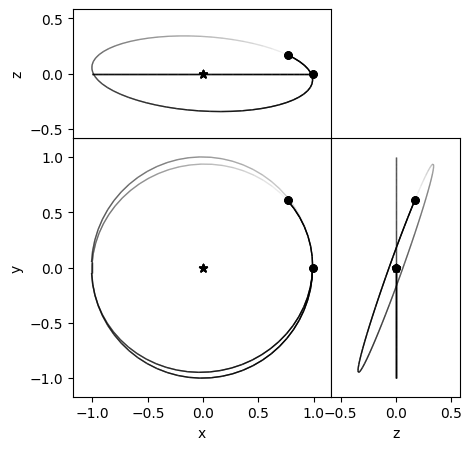

In [6]:
Omega = np.radians(10) # Ascending node
inc = np.radians(20) # Inclination
omega = np.radians(30) # Longitude of periastron
sim = rebound.Simulation()
sim.add(m=1) # central object
sim.add(a=1, e=0.01, Omega=Omega, inc=inc, omega=omega) # inclined orbit
sim.add(a=1, e=0.01) # orbit in the xy plane, periastron on the x axis
rebound.OrbitPlotSet(sim);

We can create a rotation that moves the orbit in the xy plane into the orbital plane defined by Omega, inc, and omega:

In [7]:
rot = rebound.Rotation.orbit(Omega=Omega, inc=inc, omega=omega)

After applying this rotation to the second planet, the two planets are on identical inclined orbits (the plot only shows one planet because the particles are at the same location):

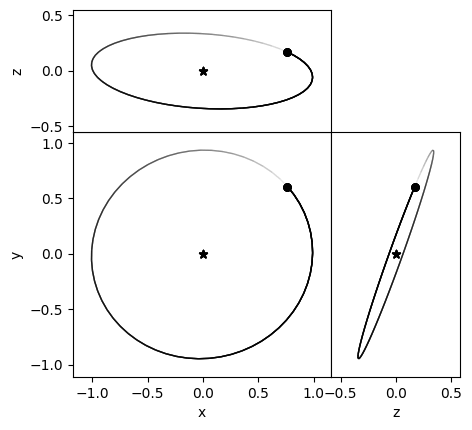

In [8]:
sim.particles[2].rotate(rot)
rebound.OrbitPlotSet(sim);

# Rotating to a reference frame align with a planet's orbit

Let's construct a simplified Solar System to demonstrate a different use case of this constructor.

In [9]:
sim = rebound.Simulation()
date = "2023-01-01 00:00"
sim.add('Sun')
sim.add('Jupiter')
sim.add('Saturn', hash='Saturn')
sim.move_to_com()
ps = sim.particles

Searching NASA Horizons for 'Sun'... 
Found: Sun (10) 
Searching NASA Horizons for 'Jupiter'... 
Found: Jupiter Barycenter (5) (chosen from query 'Jupiter')
Searching NASA Horizons for 'Saturn'... 
Found: Saturn Barycenter (6) (chosen from query 'Saturn')


The reference axes used in the above simulation uses the ecliptic as a reference plane (this is what the NASA Horions query returns by default).

Suppose we want to construct a rotation from these reference axes to reference axes aligned with Saturn's orbit (where the new z direction is along the orbit normal, and x direction is toward pericenter). This is the inverse of what the `to_orbital` constructor returns:

In [10]:
rot = rebound.Rotation.orbit(Omega=ps['Saturn'].Omega, inc=ps['Saturn'].inc, omega=ps['Saturn'].omega)

rot.inverse() * ps['Saturn'].xyz

[-5.755225420998638, -7.967620173574598, -5.440092820663267e-15]

When we act our rotation on Saturn's xyz position (in our original coordinate system, in AU), we see we get a vector with vanishing z component (good since Saturn should be in its own orbital plane!), and that Saturn is a bit past apocenter (both x and y are negative).

If we want to get the direction toward Saturn's pericenter in our ecliptic coordinate system, we can use

In [11]:
rot*[1,0,0]

[-0.03324223170028384, 0.9993183366324941, -0.016056652878168994]

# Invariable plane

Now say we realize that the ecliptic plane should have very little to do with the dynamics of Saturn and Jupiter, and we want to rotate into the invariable plane, where the z direction points along the total angular momentum. We can do:

In [12]:
rot = rebound.Rotation.to_new_axes(newz=sim.angular_momentum())

We could also have passed a `newx` vector perpendicular to newz in order to specify the new x direction. If we don't, it defaults sensibly to the line of nodes at the intersection between our reference plane (here the ecliptic) and our new reference plane (perpendicular to newz, here the invariable plane)--specifically the $z \times newz$ direction.

We can now, e.g., get Saturn's position (or any other vector) in our new coordinate system:

In [13]:
rot*ps['Saturn'].xyz

[-7.549431805655818, -6.293586822293665, -0.04934773414991059]

However, we might also want to rotate our entire Simulation into this new coordinate system, so the z axis is always a physically meaningful direction. We can do that simply with:

In [14]:
print(sim.angular_momentum())
sim.rotate(rot)
print(sim.angular_momentum())

[8.371971695560277e-05, 2.4357882968012634e-05, 0.0030550235653400053]
[0.0, -3.3881317890172014e-20, 0.0030562675410134763]


We see that before rotating our Simulation, the angular momentum was almost, but not quite along the z direction (the ecliptic is of course close to the invariable plane!), but after the rotation, the x and y components are at the level of the machine precision.

# Technical Detail: Copies vs in-place rotations

There are two ways to apply a rotation to a `Particle`, a `Vec3D`, or a `Simulation`. 

We can act (using the multiply operator `*`) a `Rotation` on ab object. As a general rule, `Rotation` * `object` always returns a copy. For example:

In [15]:
ecliptic_saturn = rot.inverse() * sim.particles['Saturn']
ecliptic_saturn.x, sim.particles['Saturn'].x

(8.148225160959612, -7.549431805655818)

In the above case, the `ecliptic_saturn` particle is a copy. The original Saturn particle in the Simulation is unchanged. 

On the other hand, if we call the `rotate` method on a REBOUND object such as `Vec3d`, `Particle`, or `Simulation`. then the object is updated in-place. For example, if we wanted to update Saturn with a rotated position (and velocity) in our simulation, we could do:

In [16]:
sim.particles['Saturn'].rotate(rot.inverse())
ecliptic_saturn.x, sim.particles['Saturn'].x

(8.148225160959612, 8.148225160959612)

Now we see that the two yield the same x value, since we've actually updated the positions of the particle in our simulation. 

In most use cases, we probably want to rotate a Simulation in place with `sim.rotate(rot)`. Note that if we do `rot*sim` we get back a shallow copy that doesn't keep any of our function pointers (see `sim.copy()`).